Team: Jui Nagarkar, Injuu Jyenis, & Adawn Symonette

**BINARY CLASSIFICATION CONFORMAL PREDICTION:**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
!pip install mapie
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_mean_width_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 1.5 MB/s eta 0:00:00


In [ ]:
heart = pd.read_csv('heart.csv')
heart.shape

(918, 12)

In [ ]:
print(heart.keys())

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


In [ ]:
heart["HeartDisease"].unique()

array([0, 1])

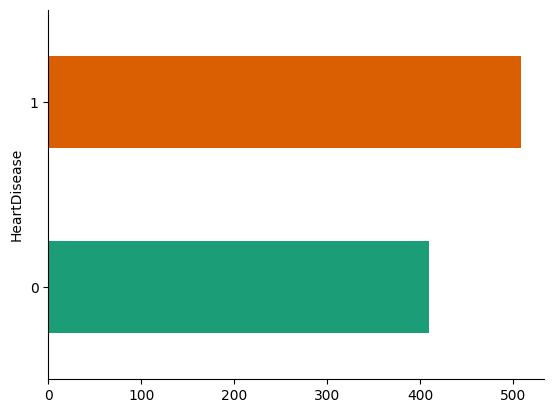

In [ ]:
heart.groupby('HeartDisease').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Labels are characters but should be integers for sklearn
le = LabelEncoder()
heart["HeartDisease"] = le.fit_transform(heart["HeartDisease"])

heart_categorical = heart.select_dtypes(include=['object'])
heart[heart_categorical.columns] = heart_categorical.apply(le.fit_transform)

#Split data into classification target and features
y = heart["HeartDisease"]
X = heart.drop("HeartDisease", axis = 1)

In [ ]:
#Split of training data
X_train, X_rest1, y_train, y_rest1 = train_test_split(X,y,train_size=0.7,random_state=2)

In [ ]:
#From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1,y_rest1,train_size=100,random_state=42)
#Split remaining data into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2,y_rest2,train_size=100,random_state=42)
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100)
model = clf.fit(X_train, y_train)

In [ ]:
#Check model accuracy on the test data
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())

Accuracy: 0.84


In [ ]:
unique_classes = sorted(set(y_test) | set(y_pred))

#Create the confusion matrix
cm = confusion_matrix(y_test,y_pred, labels=unique_classes)
print(pd.DataFrame(cm,index=unique_classes,columns=unique_classes))

    0   1
0  43  10
1   6  41


In [ ]:
cp = MapieClassifier(estimator=model,cv="prefit",method="score")
cp.fit(X_calib,y_calib)

MapieClassifier(cv='prefit', estimator=RandomForestClassifier(), method='score')

In [ ]:
y_pred, y_set = cp.predict(X_new,alpha = 0.05)
y_set = np.squeeze(y_set)
y_set_int = np.argmax(y_set, axis = 1)
for i in range(10):
  print(unique_classes[y_set_int[i]])

0
0
0
0
0
1
0
0
1
0


In [ ]:
# first count number of classes per bean
set_sizes = y_set.sum(axis = 1)
# use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts())

1    48
2    28
Name: count, dtype: int64


In [ ]:
cov = classification_coverage_score(y_new,y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.3%}'.format(cov))
print('Avg. set size: {:.5}'.format(setsize))

Coverage: 98.684%
Avg. set size: 1.3684


**Logistic Regression:**

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=0).fit(X_train, y_train)
log_pred = log_reg.predict(X_test)
print(log_pred)

In [ ]:
lr_contable = confusion_matrix(y_test,log_pred,labels=[0,1])
lr_disp = ConfusionMatrixDisplay(confusion_matrix=lr_contable,
                             display_labels=[0,1])
lr_disp.plot()

print("LR Acc: {}".format((lr_contable[0,0]+lr_contable[1,1])/np.sum(lr_contable)))